In [5]:
'''
Importing a lot of stuff so this circuit can work.
'''
from qiskit import QuantumRegister,ClassicalRegister
from qiskit import QuantumCircuit,execute, Aer
import matplotlib
from qiskit.visualization import plot_histogram
import numpy as np
from operator import add 

In [6]:
'''
Creating carry gate for quantum full adder:
'''

q = QuantumRegister(4)
carry_circ = QuantumCircuit(q,name = 'C')
carry_circ.ccx(q[1],q[2],q[3])
carry_circ.cx(q[1],q[2])
carry_circ.ccx(q[0],q[2],q[3])

#Convert to a composite gate
carry_gate = carry_circ.to_instruction()

In [7]:
'''
Creating carry dagger gate for quantum full adder:
'''
i_q = QuantumRegister(4)
c_dag_circ = QuantumCircuit(i_q,name = 'cdag')
c_dag_circ.ccx(i_q[0],i_q[2],i_q[3])
c_dag_circ.cx(i_q[1],i_q[2])
c_dag_circ.ccx(i_q[1],i_q[2],i_q[3])
#Convert to a composite gate
c_dag_gate = c_dag_circ.to_instruction()

In [8]:
'''
Creating sum gate for quantum full adder:
'''
s_q = QuantumRegister(3)
sum_circ = QuantumCircuit(s_q,name = 'S')
sum_circ.cx(s_q[1],s_q[2])
sum_circ.cx(s_q[0],s_q[2])
#Convert to a composite gate
sum_gate = sum_circ.to_instruction()

In [33]:
'''
4-bit Quantum Ripple Adder function:
'''

def Four_Bit_Ripple_Adder( Input_1, Input_2, c0, c1, c2, c3):
    q = QuantumRegister( 13, 'q' )
    c = ClassicalRegister( 5, 'c' )
    qc = QuantumCircuit( q, c )
    
    # Setting up the ancilla Cin input:
    if( c0 == 1 ):
        qc.x(q[0])
        
    if( c1 == 1 ):
        qc.x(q[3])
        
    if( c2 == 1 ):
        qc.x(q[6])
        
    if( c3 == 1 ):
        qc.x(q[9])
        
    # Setting up first binary number inputs:
    if( Input_1 & 0x01 ):
        qc.x(q[1])
    if( Input_1 & 0x02 ):
        qc.x(q[4])
    if( Input_1 & 0x04):
        qc.x(q[7])
    if( Input_1 & 0x08 ):
        qc.x(q[10])

    
    # Setting up second binary number inputs:
    if( Input_2 & 0x01 ):
        qc.x(q[2])
    if( Input_2 & 0x02 ):
        qc.x(q[5])
    if( Input_2 & 0x04 ):
        qc.x(q[8])
    if( Input_2 & 0x08 ):
        qc.x(q[11])

    # Constructing 4-bit Quantum Ripple Adder Circuit:
    qc.append(carry_gate, [q[0], q[1], q[2], q[3]])
    qc.append(carry_gate, [q[3], q[4], q[5], q[6]])
    qc.append(carry_gate, [q[6], q[7], q[8], q[9]])
    qc.append(carry_gate, [q[9], q[10], q[11], q[12]])
   
    qc.cx(q[10], q[11])
    
    qc.append(sum_gate, [q[9], q[10], q[11]])
    qc.append(c_dag_gate, [q[6],q[7],q[8],q[9]])
    qc.append(sum_gate, [q[6],q[7],q[8]])
    qc.append(c_dag_gate, [q[3], q[4], q[5], q[6]])
    qc.append(sum_gate, [q[3],q[4],q[5]])
    qc.append(c_dag_gate, [q[0], q[1], q[2], q[3]])
    qc.append(sum_gate, [q[0], q[1], q[2]])

    qc.barrier()
    
    # Measuring COUT, s0, s1, s2, s3
    qc.measure(q[12], c[4])
    qc.measure(q[11], c[3])
    qc.measure(q[8], c[2])
    qc.measure(q[5], c[1])
    qc.measure(q[2], c[0])
    
    return qc

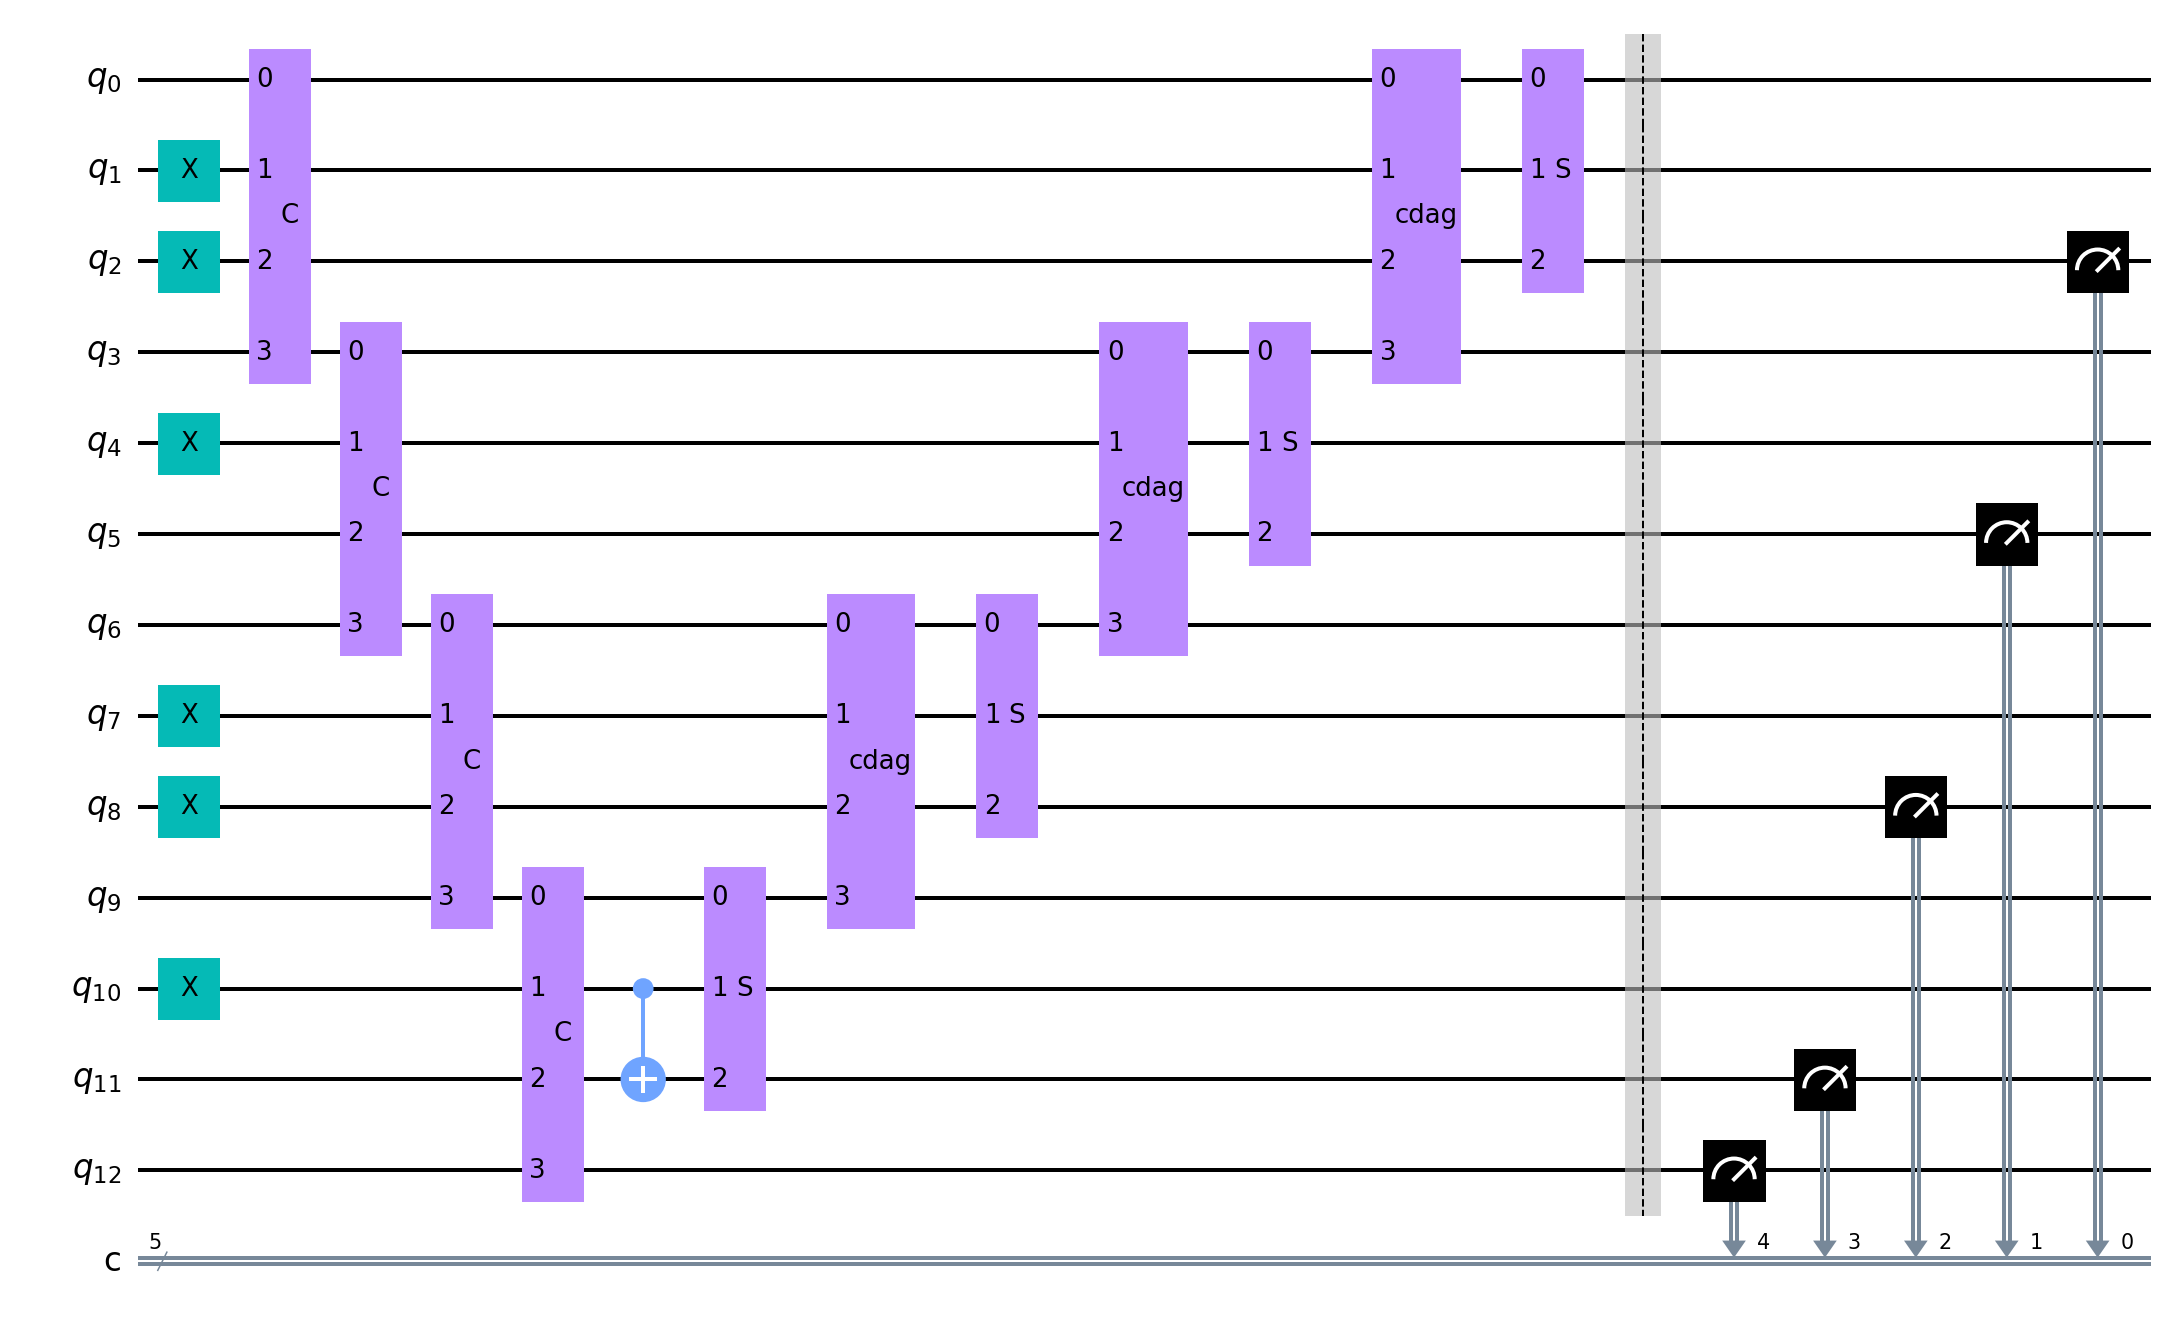

In [42]:
'''
ancilla qubits need to be set to zero otherwise the circuit doesn't work well. This is very inefficient though, because
this uses a lot of qubits to add classical bits. To be more specific, this circuit requires a total of 13 qubits to add.
This is more than the majority-unmajority circuit that uses 10 qubits. Another benefit to the other circuit is that 
it uses in-place carry, rather than defining carry qubits right off the bat. That's why that circuit only needs one ancilla
qubit.
'''


Input_1 = 15
Input_2 = 5
c0 = 0
c1 = 0
c2 = 0
c3 = 0

QC = Four_Bit_Ripple_Adder( Input_1, Input_2, c0, c1, c2, c3)
    
QC.draw( output='mpl', scale = 2.0 )

{'10100': 1024}


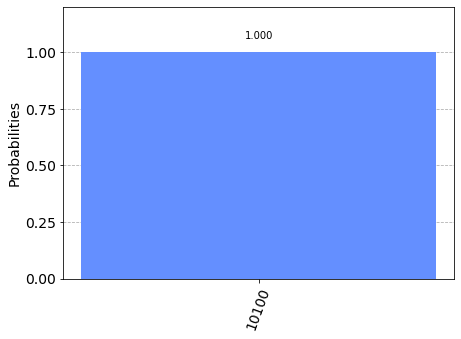

In [45]:
#Create a simulator to perform noisy simulation using the qasm_simulator 
sim = Aer.get_backend('qasm_simulator')


#Perform the noisy simulation using the qasm_Simulator and repeat 1024 times
job = execute(QC,backend=sim,shots=1024)
#Obtain the results of the job submitted
result = job.result()
#Obtain the results of the simulation
counts= result.get_counts(QC)
print(counts)

plot_histogram(counts)